In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Draw inline
%matplotlib inline

# Set figure aesthetics
sns.set_style("white", {'ytick.major.size': 10.0})
sns.set_context("poster", font_scale=1.1)

## Data Exploration

In [2]:
# Load the data into DataFrames
train_users = pd.read_csv('train_users_2.csv')
test_users = pd.read_csv('test_users.csv')

Lets check how much the different signup methods have been used.

In [24]:
train_users['signup_method'].value_counts()

basic       152897
facebook     60008
google         546
Name: signup_method, dtype: int64

Let's get those together so we can work with all the data.

In [3]:
# Merge train and test users
users = pd.concat((train_users, test_users), axis=0, ignore_index=True)

# Remove ID's since now we are not interested in making predictions
users.drop('id',axis=1, inplace=True)

users.head()

,affiliate_channel,affiliate_provider,age,country_destination,date_account_created,date_first_booking,first_affiliate_tracked,first_browser,first_device_type,gender,language,signup_app,signup_flow,signup_method,timestamp_first_active
0,direct,direct,NaN,NDF,2010-06-28,NaN,untracked,Chrome,Mac Desktop,-unknown-,en,Web,0,facebook,20090319043255
1,seo,google,38.0,NDF,2011-05-25,NaN,untracked,Chrome,Mac Desktop,MALE,en,Web,0,facebook,20090523174809
2,direct,direct,56.0,US,2010-09-28,2010-08-02,untracked,IE,Windows Desktop,FEMALE,en,Web,3,basic,20090609231247
3,direct,direct,42.0,other,2011-12-05,2012-09-08,untracked,Firefox,Mac Desktop,FEMALE,en,Web,0,facebook,20091031060129
4,direct,direct,41.0,US,2010-09-14,2010-02-18,untracked,Chrome,Mac Desktop,-unknown-,en,Web,0,basic,20091208061105


### Missing Data

In [4]:
users.gender.replace('-unknown-', np.nan, inplace=True)

Now let's see how much data we are missing. For this purpose let's compute the NaN percentage of each feature.

In [5]:
users_nan = (users.isnull().sum() / users.shape[0]) * 100
users_nan[users_nan > 0].drop('country_destination')

age                        42.412365
date_first_booking         67.733998
first_affiliate_tracked     2.208335
gender                     46.990169
dtype: float64

We have quite a lot of *NaN* in the `age` and `gender` wich will yield in lesser performance of the classifiers we will build.

In [6]:
users[users.age > 122]['age'].describe()

count     830.000000
mean     2002.620482
std        94.201344
min       132.000000
25%      2014.000000
50%      2014.000000
75%      2014.000000
max      2014.000000
Name: age, dtype: float64

It's seems that the weird values are caused by the appearance of 2014. 

In [7]:
users[users.age < 18]['age'].describe()

count    188.000000
mean      12.718085
std        5.764569
min        1.000000
25%        5.000000
50%       16.000000
75%       17.000000
max       17.000000
Name: age, dtype: float64

The young users seems to be under an acceptable range being the 50% of those users above 16 years old. 
We will need to hande the outliers. The simple thing that came to my mind it's to set an acceptance range and put those out of it to NaN.

In [8]:
users.loc[users.age > 95, 'age'] = np.nan
users.loc[users.age < 13, 'age'] = np.nan

### Data Types

Let's treat each feature as what they are. This means we need to transform into categorical those features that we treas as categories and the same with the dates:

In [9]:
categorical_features = [
    'affiliate_channel',
    'affiliate_provider',
    'country_destination',
    'first_affiliate_tracked',
    'first_browser',
    'first_device_type',
    'gender',
    'language',
    'signup_app',
    'signup_method'
]

for categorical_feature in categorical_features:
    users[categorical_feature] = users[categorical_feature].astype('category')

In [10]:
users['date_account_created'] = pd.to_datetime(users['date_account_created'])
users['date_first_booking'] = pd.to_datetime(users['date_first_booking'])
users['date_first_active'] = pd.to_datetime((users.timestamp_first_active // 1000000), format='%Y%m%d')

### Visualizing the Data

Usually, looking at tables, percentiles, means, and other several measures at this state is rarely useful unless you know very well your data.

For me, it's usually better to visualize the data in some way. Visualization makes me see the outliers and errors immediately!

#### Gender

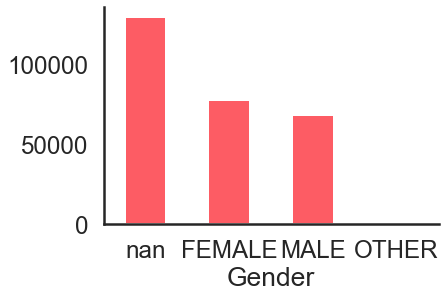

In [11]:
users.gender.value_counts(dropna=False).plot(kind='bar', color='#FD5C64', rot=0)
plt.xlabel('Gender')
sns.despine()

As we've seen before at this plot we can see the ammount of missing data in perspective. Also, notice that there is a slight difference between user gender.


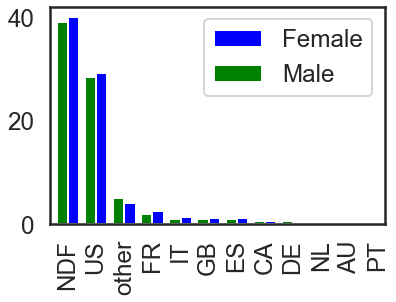

In [27]:
Fav_F_Dest=users.loc[users.gender=='FEMALE','country_destination'].value_counts()/women *100
Fav_M_Dest=users.loc[users.gender=='MALE','country_destination'].value_counts()/men*100
width=0.4
Fav_F_Dest.plot(kind='bar',label='Female',color='b',position=0,width=width)
Fav_M_Dest.plot(kind='bar',label='Male',color='g',position=1,width=width)
plt.legend()

#### Age

Now that I know there is no difference between male and female reservations at first sight I'll dig into the age.

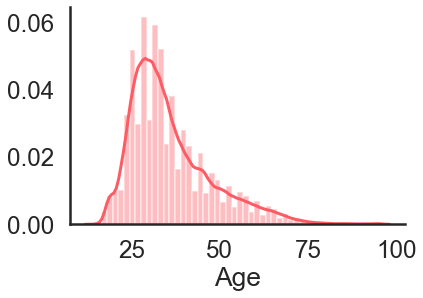

In [14]:
sns.distplot(users.age.dropna(), color='#FD5C64')
plt.xlabel('Age')
sns.despine()

As expected, the common age to travel is between 25 and 40. Let's see if, for example, older people travel in a different way. Let's pick an arbitrary age to split into two groups.

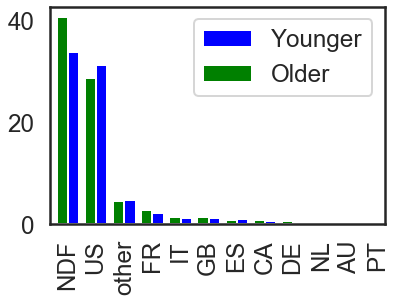

In [29]:
young=sum(users.age<40)
old=sum(users.age>40)
Young_dest=users.loc[users.age<40,'country_destination'].value_counts()/young *100
Old_dest=users.loc[users.age>40,'country_destination'].value_counts()/old * 100
Young_dest.plot(kind='bar',color='b',position=0,width=width,label='Younger')
Old_dest.plot(kind='bar',color='g',position=1,width=width,label='Older')
plt.legend()

In [16]:
print((sum(users.language == 'en') / users.shape[0])*100)

96.3675888323952


With the 96% of users using English as their language, it is understandable that a lot of people stay in the US. 

#### Dates

To see the dates of our users and the timespan of them, let's plot the number of accounts created by time:

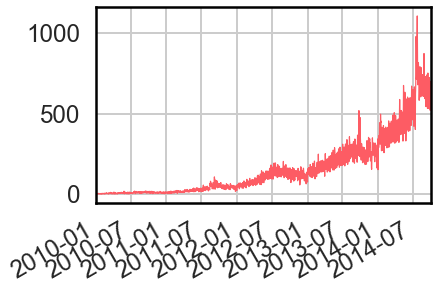

In [17]:
sns.set_style("whitegrid", {'axes.edgecolor': '0'})
sns.set_context("poster", font_scale=1.1)
users.date_account_created.value_counts().plot(kind='line', linewidth=1.2, color='#FD5C64')

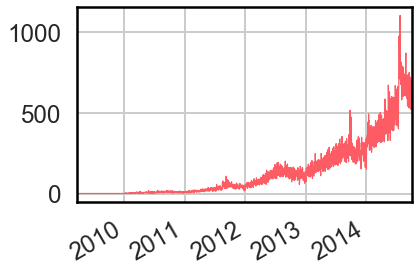

In [18]:
users.date_first_active.value_counts().plot(kind='line', linewidth=1.2, color='#FD5C64')

We can se that's almost the same as `date_account_created`, and also, notice the small peaks. We can, either smooth the graph or dig into those peaks. Let's dig in:

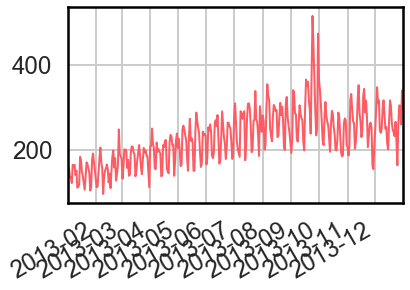

In [19]:
users_2013 = users[users['date_first_active'] > pd.to_datetime(20130101, format='%Y%m%d')]
users_2013 = users_2013[users_2013['date_first_active'] < pd.to_datetime(20140101, format='%Y%m%d')]
users_2013.date_first_active.value_counts().plot(kind='line', linewidth=2, color='#FD5C64')
plt.show()

At first sight we can see a small pattern, there are some peaks at the same distance. Looking more closely:

In [20]:
weekdays = []
for date in users.date_account_created:
    weekdays.append(date.weekday())
weekdays = pd.Series(weekdays)

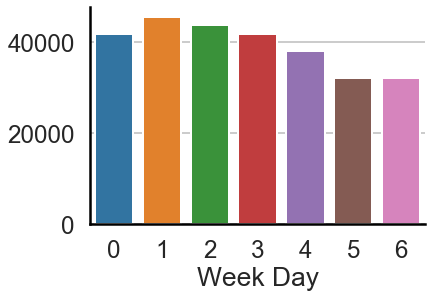

In [21]:
sns.barplot(x = weekdays.value_counts().index, y=weekdays.value_counts().values, order=range(0,7))
plt.xlabel('Week Day')
sns.despine()

The local minimums where the Sundays(where the people use less *the Internet*), and it's usually to hit a maximum at Tuesdays!

The last date related plot I want to see is the next:

Slicing the data for the users who have booked in the year of 2014 and 2015.

In [31]:
dest_2014_=users.loc[users.date_first_booking > pd.to_datetime(20140101,format='%Y%m%d')]

In [32]:
dest_2014_=dest_2014_.loc[dest_2014_.date_first_booking<pd.to_datetime(20150101,format='%Y%m%d')]

In [33]:
acc_2014=users.loc[users.date_account_created>pd.to_datetime(20140101,format='%Y%m%d')]

In [34]:
acc_2014=acc_2014.loc[acc_2014.date_account_created<pd.to_datetime(20150101,format='%Y%m%d')]

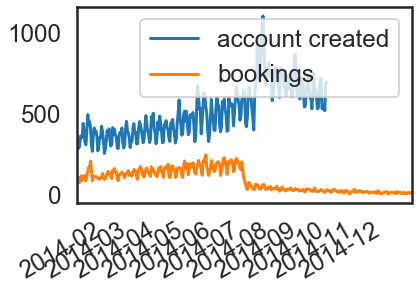

In [35]:
acc_2014['date_account_created'].value_counts().plot(kind='line',label='account created')
dest_2014_['date_first_booking'].value_counts().plot(kind='line',label='bookings')
plt.legend()